# Feature extraction using Autoencoders

In [4]:
# pip install torchinfo


  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import time
import torch.nn.functional as F

from pathlib import Path
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchinfo import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
NUM_CLASSES = 5
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
IMAGE_DATASET_PATH = str(Path().absolute()) + "/dataset"
MANUAL_SEED= 42
NUM_EPOCHS = 100
LEARNING_RATE=0.005
VALID_SIZE=0.1
FEATURE_MODEL_TRAINING_SIZE=0.8
CLASSIFIER_TRAINING_SIZE=0.2
# Set random seed for reproducibility
np.random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

In [3]:
def checkpoint(model, optimizer, filename):
    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, filename)
    
def resume(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [5]:
# Define a custom dataset class for autoencoder training without labels
class ImageFolderNoLabel(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

In [7]:
train_transforms = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transforms = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

Autoencoder training dataset don't have any labels included since inclusion of the labels will make it to semi-supervised learning. The goal of this study is to use unsupervised learning to extract features from images.

In [8]:
train_dataset = torchvision.datasets.ImageFolder(root='dataset/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root='dataset/test', transform=test_transforms)
ae_train_dataset = ImageFolderNoLabel(root='dataset/train', transform=train_transforms)
ae_valid_dataset = ImageFolderNoLabel(root='dataset/train', transform=train_transforms)
ae_test_dataset = ImageFolderNoLabel(root='dataset/test', transform=train_transforms)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,                                     
    shuffle=False)
ae_test_loader = torch.utils.data.DataLoader(
    ae_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## TO-DO: REFACTOR THIS TO A FUNCTION
# Split the training data to autoencoder data and classifier training data
# Autoencoder training will be 80% of the training data
# Classifier data will be 20% of the training data
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(CLASSIFIER_TRAINING_SIZE * num_train))
np.random.shuffle(indices)
ae_train_idx, cl_train_idx = indices[split:], indices[:split]
ae_train_sampler = SubsetRandomSampler(ae_train_idx)
cl_train_sampler = SubsetRandomSampler(cl_train_idx)



ae_validation_size = int(np.floor(VALID_SIZE * len(ae_train_idx)))
cl_validation_size = int(np.floor(VALID_SIZE * len(cl_train_idx)))
ae_validation_idx = np.random.choice(ae_train_idx, ae_validation_size, replace=False)
cl_validation_idx = np.random.choice(cl_train_idx, cl_validation_size, replace=False)
ae_validation_sampler = SubsetRandomSampler(ae_validation_idx)
cl_validation_sampler = SubsetRandomSampler(cl_validation_idx)

# Load the training dataset for AutoEncoder
ae_train_loader = torch.utils.data.DataLoader(
    ae_train_dataset, 
    batch_size=BATCH_SIZE,
    sampler=ae_train_sampler
)

ae_validation_loader = torch.utils.data.DataLoader(
    ae_train_dataset, 
    batch_size=BATCH_SIZE,
    sampler=ae_validation_sampler
)

# Load the dataset for Classifier
cl_train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    sampler=cl_train_sampler
)

# Load the validation dataset for Classifier
cl_validation_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    sampler=cl_validation_sampler
)



In [9]:
len(ae_train_idx), len(cl_train_idx), len(ae_validation_idx), len(cl_validation_idx), len(train_dataset), len(test_dataset), len(ae_test_dataset)

(54000, 13500, 5400, 1350, 67500, 7500, 7500)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


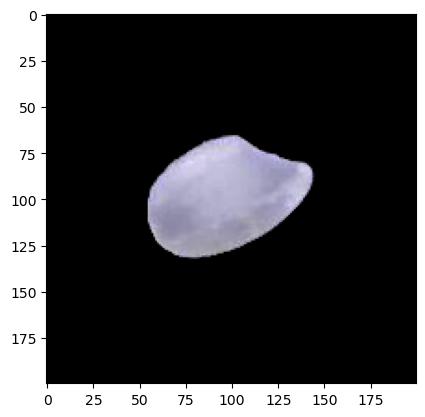

In [8]:
dataiter = iter(ae_train_loader)
images = next(dataiter)
images.shape

for i, img  in enumerate(images):
  plt.imshow(img.permute(1,2,0))
  plt.show()
  # print(f"Label: {label}")
  break

## AE Model

In [9]:
class AutoEncoderModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=1000, act_fn=nn.ReLU()):
        super(AutoEncoderModel, self).__init__()
        self.encoderLayer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # (200, 200)
            act_fn,
            nn.Conv2d(out_channels, out_channels, 3, padding=1), 
            act_fn,
            nn.Conv2d(out_channels, 2 * out_channels, 3, padding=1, stride=2), # (100, 100)
            act_fn,
            nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2), # (50, 50)
            act_fn,
            nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
            act_fn,
            nn.Flatten(),
            nn.Linear(4*out_channels*50*50, latent_dim),
            act_fn
        )
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * out_channels * 50 * 50),
            act_fn,
        )
        self.decoderLayer1 = nn.Sequential(
            nn.ConvTranspose2d(4 * out_channels, 4 * out_channels, 3, padding=1), # (50, 50)
            act_fn,
            nn.ConvTranspose2d(4 * out_channels, 2 * out_channels, 3, padding=1, 
                               stride=2, output_padding=1), # (100, 100)
            act_fn,
            nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                               stride=2, output_padding=1), # (200, 200)
            act_fn,
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
        )
        
    def encode(self, x):
        x = x.view(-1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])
        encoder = self.encoderLayer1(x)
        return encoder
        
    def forward(self, x):
        encoder = self.encode(x)
        output = self.linear(encoder)
        output = output.view(-1, 4 * 16, 50, 50)
        decoder = self.decoderLayer1(output)
        
        return decoder
#         return encoder

In [10]:
autoencoder = AutoEncoderModel(latent_dim=200).to(device)

In [11]:
summary(autoencoder, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderModel                         [32, 3, 200, 200]         --
├─Sequential: 1-1                        [32, 200]                 32,071,832
│    └─Conv2d: 2-1                       [32, 16, 200, 200]        448
├─Sequential: 1-16                       --                        (recursive)
│    └─ReLU: 2-2                         [32, 16, 200, 200]        --
├─Sequential: 1-13                       --                        (recursive)
│    └─Conv2d: 2-3                       [32, 16, 200, 200]        2,320
├─Sequential: 1-16                       --                        (recursive)
│    └─ReLU: 2-4                         [32, 16, 200, 200]        --
├─Sequential: 1-13                       --                        (recursive)
│    └─Conv2d: 2-5                       [32, 32, 100, 100]        4,640
├─Sequential: 1-16                       --                        (recursive)
│    └─ReLU: 2-6         

In [12]:
autoencoder_1000 = AutoEncoderModel(latent_dim=1000).to(device)

In [20]:
summary(autoencoder_1000, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderModel                         [32, 3, 200, 200]         --
├─Sequential: 1-1                        [32, 1000]                160,072,632
│    └─Conv2d: 2-1                       [32, 16, 200, 200]        448
├─Sequential: 1-16                       --                        (recursive)
│    └─ReLU: 2-2                         [32, 16, 200, 200]        --
├─Sequential: 1-13                       --                        (recursive)
│    └─Conv2d: 2-3                       [32, 16, 200, 200]        2,320
├─Sequential: 1-16                       --                        (recursive)
│    └─ReLU: 2-4                         [32, 16, 200, 200]        --
├─Sequential: 1-13                       --                        (recursive)
│    └─Conv2d: 2-5                       [32, 32, 100, 100]        4,640
├─Sequential: 1-16                       --                        (recursive)
│    └─ReLU: 2-6        

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

In [51]:
start = time.perf_counter()
best_accuracy = 1
start_epoch = 0
start_step = 0
early_stop_thresh = 3
val_loss_per_epoch = {}
train_loss_per_epoch = {}

if start_epoch > 0:
    resume_epoch = start_epoch - 1
    print("LOADING MODEL...")
    resume(autoencoder, optimizer, f"AE-epoch-{resume_epoch}-full.pth")

for epoch in range(NUM_EPOCHS):
    # Training phase
    autoencoder.train()
    train_loss = 0.0
    print(f"STARTING TRAINING AT EPOCH {epoch} ")
    start_epoch_timer = time.perf_counter()
    for i, data in enumerate(ae_train_loader):
        images = data.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if i % 500 == 0:
            print(f"IMAGE TRAINING AT {i}")
    train_loss /= len(ae_train_loader.dataset)
    
    # Validation phase
    autoencoder.eval()
    print(f"STARTING EVALUATION. CURRENT TRAINING LOSS: {train_loss}")
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(ae_validation_loader):
            images = data.to(device)
            outputs = autoencoder(images)
            loss = criterion(outputs, images)  # Reconstruction loss
            val_loss += loss.item()
    val_loss /= len(ae_validation_loader.dataset)
    
    end_epoch_timer = time.perf_counter()
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss}, Val Loss: {val_loss}. TIME: {end_epoch_timer - start_epoch_timer} seconds")
    
    train_loss_per_epoch[epoch] = train_loss
    val_loss_per_epoch[epoch] = val_loss
        
    if val_loss < best_accuracy:
        print(f"Best loss changed: {val_loss:7f}")
        best_accuracy = val_loss
        best_epoch = epoch
        checkpoint(autoencoder, optimizer, "AE_best_model.pth")
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
end = time.perf_counter()
print(f'{end - start} seconds')

STARTING TRAINING AT EPOCH 0 
IMAGE TRAINING AT 0
IMAGE TRAINING AT 500
IMAGE TRAINING AT 1000
IMAGE TRAINING AT 1500
STARTING EVALUATION. CURRENT TRAINING LOSS: 0.0011114409782475344
Epoch [1/100], Train Loss: 0.0011114409782475344, Val Loss: 2.2550882316297954e-05. TIME: 1583.6832201999998 seconds
Best loss changed: 0.000023
STARTING TRAINING AT EPOCH 1 
IMAGE TRAINING AT 0
IMAGE TRAINING AT 500
IMAGE TRAINING AT 1000
IMAGE TRAINING AT 1500
STARTING EVALUATION. CURRENT TRAINING LOSS: 0.00018897248912188742
Epoch [2/100], Train Loss: 0.00018897248912188742, Val Loss: 1.7071922716719132e-05. TIME: 1555.9743215000003 seconds
Best loss changed: 0.000017
STARTING TRAINING AT EPOCH 2 
IMAGE TRAINING AT 0
IMAGE TRAINING AT 500
IMAGE TRAINING AT 1000
IMAGE TRAINING AT 1500
STARTING EVALUATION. CURRENT TRAINING LOSS: 0.0001517731629036091
Epoch [3/100], Train Loss: 0.0001517731629036091, Val Loss: 1.365291953638748e-05. TIME: 1551.3684513000007 seconds
Best loss changed: 0.000014
STARTING TRA

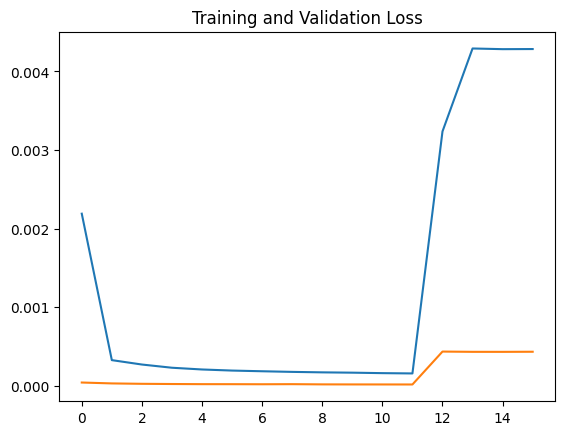

In [8]:
# Training/Validation loss for 200-latent Dimension
plt.plot(list(train_loss_per_epoch.keys()), list(train_loss_per_epoch.values()), label='Training Loss')
plt.plot(list(val_loss_per_epoch.keys()), list(val_loss_per_epoch.values()), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()

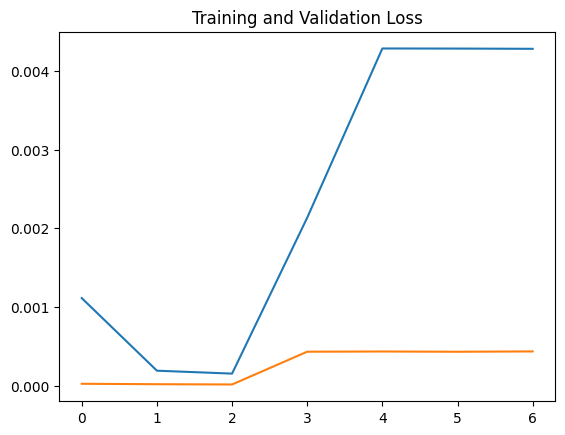

In [52]:
# Training/Validation loss for 1000-latent Dimension
plt.plot(list(train_loss_per_epoch.keys()), list(train_loss_per_epoch.values()), label='Training Loss')
plt.plot(list(val_loss_per_epoch.keys()), list(val_loss_per_epoch.values()), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()

## Load the best CAE models

Load the best CAE models for 200 latent dimension and 1000 latent dimension. Test it on the test data and then use it to extract features from the dataset

In [15]:
def test(autoencoder, test_loader):
  per_batch_loss = {}
  autoencoder.eval()
  with torch.no_grad():
    val_loss = 0.0
    for i, data in enumerate(test_loader):
        images = data.to(device)
        outputs = autoencoder(images)

        if i == 0:
            img = images[0].cpu()
            reconstructed_image = outputs[0].cpu()
            fig, axes = plt.subplots(1, 2)
            fig.set_size_inches(10, 10)
            axes[0].imshow(img.permute(1,2,0)) 
            axes[0].set_title('Original image')
            axes[0].axis('off')
            axes[1].imshow(reconstructed_image.permute(1,2,0))
            axes[1].set_title('Reconstruction')
            axes[1].axis('off')

        loss = criterion(outputs, images)  # Reconstruction loss
        per_batch_loss[i] = loss.item()
        val_loss += loss.item()
    val_loss /= len(test_loader.dataset)
    print(f"VAL LOSS FOR TEST DATA: {val_loss:7f}")
  return per_batch_loss

In [16]:
resume(autoencoder, optimizer, f"AE_best_model_200.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VAL LOSS FOR TEST DATA: 0.000222


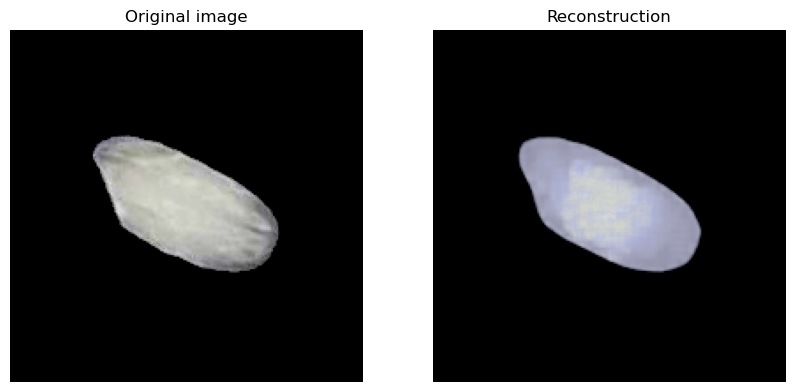

In [17]:
per_batch_loss_200 = test(autoencoder, ae_test_loader)

In [18]:
resume(autoencoder_1000, optimizer, f"AE_best_model.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VAL LOSS FOR TEST DATA: 0.000204


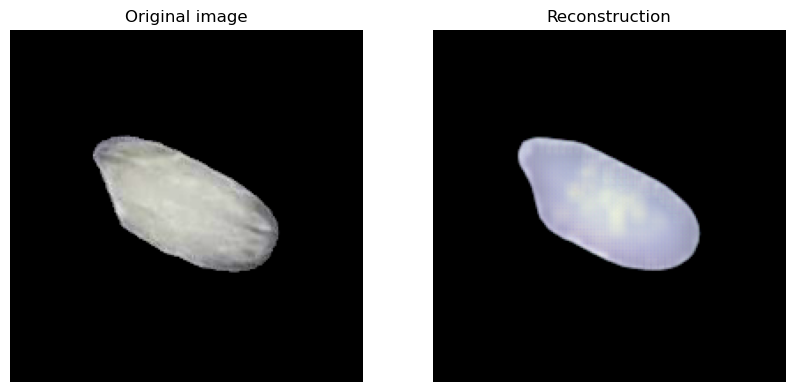

In [19]:
per_batch_loss_1000 = test(autoencoder_1000, ae_test_loader)

In [23]:
autoencoder

AutoEncoderModel(
  (encoderLayer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=160000, out_features=200, bias=True)
    (14): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=200, out_features=160000, bias=True)
    (1): ReLU()
  )
  (decoderLayer1): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, k

In [22]:
def graph_loss(per_batch_loss, title="Per Batch Loss"):
  plt.plot(list(per_batch_loss.keys()), list(per_batch_loss.values()), label='Training Loss')
  plt.title(title)
  plt.show()

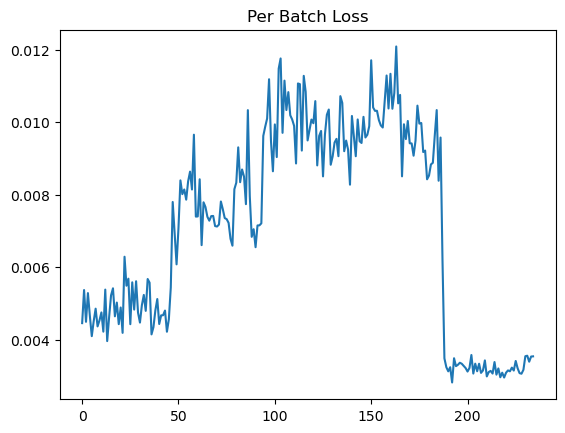

In [23]:
graph_loss(per_batch_loss_200)

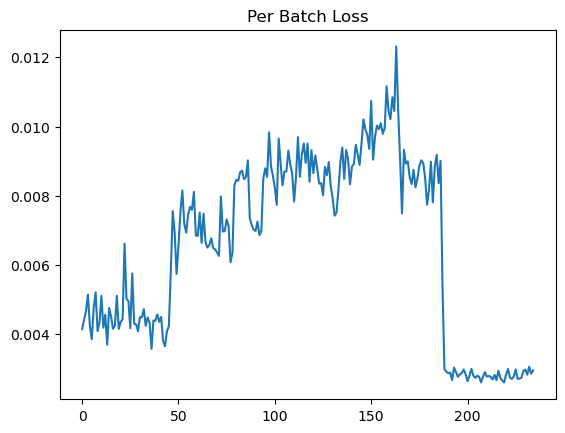

In [24]:
graph_loss(per_batch_loss_1000)

## Freezing the pretrained model
Freeze the pretrained autoencoders so that it won't be included in the gradient computation

In [64]:
for param in autoencoder.parameters():
  param.requires_grad = False

In [65]:
for param in autoencoder_1000.parameters():
  param.requires_grad = False

## Clasifiers

Use the autoencoders for the classifiers. Start with the 200 latent dimension encoder

In [146]:
class Net(nn.Module):
    def __init__(self, num_classes, autoencoder, latent_dim=200):
        super(Net, self).__init__()
        self.autoEncoder = autoencoder
        self.fc1 = nn.Linear(latent_dim, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.autoEncoder.encode(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [147]:
classifier_200 = Net(NUM_CLASSES, autoencoder, latent_dim=200)

In [148]:
summary(classifier_200, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 5]                   --
├─AutoEncoderModel: 1-1                  --                        160,187
│    └─Sequential: 2-1                   [32, 200]                 32,071,832
│    │    └─Conv2d: 3-1                  [32, 16, 200, 200]        (448)
│    └─Sequential: 2-14                  --                        (recursive)
│    │    └─ReLU: 3-2                    [32, 16, 200, 200]        --
│    └─Sequential: 2-13                  --                        (recursive)
│    │    └─Conv2d: 3-3                  [32, 16, 200, 200]        (2,320)
│    └─Sequential: 2-14                  --                        (recursive)
│    │    └─ReLU: 3-4                    [32, 16, 200, 200]        --
│    └─Sequential: 2-13                  --                        (recursive)
│    │    └─Conv2d: 3-5                  [32, 32, 100, 100]        (4,640)
│    └─Sequential: 2-14

In [149]:
def test(model, test_loader):
  model.eval()
  per_batch_accuracy = {}
  per_batch_loss = {}
  classes = list(train_dataset.class_to_idx.keys())
  criterion = nn.CrossEntropyLoss()

  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(NUM_CLASSES)]
      n_class_samples = [0 for i in range(NUM_CLASSES)]
      val_loss = 0.0
      for i, (images, labels) in enumerate(test_loader):
          images = images.to(device)
          labels = labels.to(device)
          
          outputs = model(images)
  #         max returns (value ,index)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          
          per_batch_accuracy[i] = (predicted == labels).sum().item() / labels.size(0)
          per_batch_loss[i] = loss.item()
          
          for i in range(labels.size(dim=0)):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1

      acc = 100.0 * n_correct / n_samples
      print(f'Accuracy of the network: {acc} %')
      
      for i in range(NUM_CLASSES):
          acc = 100.0 * n_class_correct[i] / n_class_samples[i]
          print(f'Accuracy of {classes[i]}: {acc} %')
          
  return per_batch_accuracy, per_batch_loss


In [150]:
def train(model, train_loader, valid_loader, filename):
  total_step = len(train_loader)
  start = time.perf_counter()
  best_accuracy = -1
  start_epoch = 0
  start_step = 0
  early_stop_thresh = 5
  val_loss_per_epoch = {}
  train_loss_per_epoch = {}
  train_accuracy_per_epoch = {}
  val_accuracy_per_epoch = {}
  total_step = len(train_loader)
  classes = list(train_dataset.class_to_idx.keys())
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

  if start_epoch > 0:
      resume_epoch = start_epoch - 1
      step_number = "full" if start_step == 1689 else start_step
      print("LOADING MODEL...")
      resume(model, optimizer, f"PCACNN-epoch-{resume_epoch}-full.pth")

  for epoch in range(start_epoch, NUM_EPOCHS):
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(NUM_CLASSES)]
      n_class_samples = [0 for i in range(NUM_CLASSES)]
      model.train()
      start_epoch_timer = time.perf_counter()
      train_loss = 0.0
      
      for i, (images, labels) in enumerate(train_loader):
          if i < start_step:
              continue
          
          if i == start_step:
              print(f"Starting the training process at {i} step, epoch {epoch + 1}...")
          
          # Move tensors to the configured device
          images = images.to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          
          for y in range(labels.size(dim=0)):
              label = labels[y]
              pred = predicted[y]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          if (i + 1) % 100 == 0:
              end_batch_timer = time.perf_counter()
  #             checkpoint(model, optimizer, f"VGG-epoch-{epoch}-{i}.pth")
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Seconds per 600 images: {}'.format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(), (end_batch_timer - start_epoch_timer)))
      train_loss /= len(train_loader.dataset)
      
      if start_step <= 0:
          acc = 100.0 * n_correct / n_samples
          end_epoch_timer = time.perf_counter()
          train_accuracy_per_epoch[epoch] = acc
        #   checkpoint(model, optimizer, f"AECNN-epoch-{epoch}-full.pth")
          print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Accuracy of the network: {acc} %, Epoch Training Time: {end_epoch_timer - start_epoch_timer}')

          for i in range(NUM_CLASSES):
              acc = 100.0 * n_class_correct[i] / n_class_samples[i]
              print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Accuracy of {classes[i]} for training: {acc} %. Train Loss {train_loss}')
          print("------------------------------------------------------------")
              
  # Validation
  # No validation at the moment.
      model.eval()
      with torch.no_grad():
          print(f"VALIDATING THE MODEL FOR EPOCH {epoch + 1}")
          correct = 0
          total = 0
          val_loss = 0.0
          for images, labels in valid_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              del images, labels, outputs
          val_loss /= len(valid_loader.dataset)
          
          acc = correct / total
          print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * acc)) 
          print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss}, Val Loss: {val_loss}. TIME: {end_epoch_timer - start_epoch_timer} seconds")
          
          train_loss_per_epoch[epoch] = train_loss
          val_loss_per_epoch[epoch] = val_loss
          val_accuracy_per_epoch[epoch] = acc
          # Early stopping
          if acc > best_accuracy:
              print(f"Best accuracy changed: {acc:7f}")
              best_accuracy = acc
              best_epoch = epoch
              checkpoint(model, optimizer, f"{filename}_best_model.pth")
          elif epoch - best_epoch > early_stop_thresh:
              print("Early stopped training at epoch %d" % epoch)
              break  # terminate the training loop
          print("------------------------------------------------------------")
  end = time.perf_counter()
  print(f'{end - start} seconds')
  return val_loss_per_epoch, train_loss_per_epoch, train_accuracy_per_epoch, val_accuracy_per_epoch, optimizer

In [199]:
def graph_train_valid(train_loss_per_epoch, val_loss_per_epoch, title='Training and Validation Loss', label1="Training Loss", label2="Validation Loss", location="upper right"):
  plt.plot(list(train_loss_per_epoch.keys()), list(train_loss_per_epoch.values()), label=label1)
  plt.plot(list(val_loss_per_epoch.keys()), list(val_loss_per_epoch.values()), label=label2)
  plt.legend(loc=location)
  plt.title(title)
  plt.show()

In [193]:
def update_accuracy(t):
  for key in t:
    t[key] = t[key] * 100

In [152]:
train_history = train(classifier_200, cl_train_loader, cl_validation_loader, "AECNN_200")

Starting the training process at 0 step, epoch 1...
Epoch [1/100], Step [100/422], Loss: 0.3014, Seconds per 600 images: 7.218164200000501
Epoch [1/100], Step [200/422], Loss: 0.1245, Seconds per 600 images: 14.358038299999862
Epoch [1/100], Step [300/422], Loss: 0.2405, Seconds per 600 images: 21.5419038
Epoch [1/100], Step [400/422], Loss: 0.0559, Seconds per 600 images: 28.774391699999796
Epoch [1/100]: Accuracy of the network: 90.97777777777777 %, Epoch Training Time: 30.384758000000147
Epoch [1/100]: Accuracy of Arborio for training: 83.66729678638941 %. Train Loss 0.0016359497673809529
Epoch [1/100]: Accuracy of Basmati for training: 92.88361749444033 %. Train Loss 0.0016359497673809529
Epoch [1/100]: Accuracy of Ipsala for training: 98.1798325445941 %. Train Loss 0.0016359497673809529
Epoch [1/100]: Accuracy of Jasmine for training: 90.55982436882546 %. Train Loss 0.0016359497673809529
Epoch [1/100]: Accuracy of Karacadag for training: 89.31639895405304 %. Train Loss 0.001635949

In [153]:
resume(classifier_200, train_history[4], f"AECNN_200_best_model.pth")

In [154]:
test_history = test(classifier_200, test_loader)

Accuracy of the network: 94.82666666666667 %
Accuracy of Arborio: 95.53333333333333 %
Accuracy of Basmati: 97.86666666666666 %
Accuracy of Ipsala: 99.86666666666666 %
Accuracy of Jasmine: 83.4 %
Accuracy of Karacadag: 97.46666666666667 %


### 1000 Dimension classifier

In [164]:
classifier_1000 = Net(NUM_CLASSES, autoencoder_1000, latent_dim=1000)

In [165]:
summary(classifier_1000, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 5]                   --
├─AutoEncoderModel: 1-1                  --                        159,387
│    └─Sequential: 2-1                   [32, 1000]                160,072,632
│    │    └─Conv2d: 3-1                  [32, 16, 200, 200]        (448)
│    └─Sequential: 2-14                  --                        (recursive)
│    │    └─ReLU: 3-2                    [32, 16, 200, 200]        --
│    └─Sequential: 2-13                  --                        (recursive)
│    │    └─Conv2d: 3-3                  [32, 16, 200, 200]        (2,320)
│    └─Sequential: 2-14                  --                        (recursive)
│    │    └─ReLU: 3-4                    [32, 16, 200, 200]        --
│    └─Sequential: 2-13                  --                        (recursive)
│    │    └─Conv2d: 3-5                  [32, 32, 100, 100]        (4,640)
│    └─Sequential: 2-1

In [166]:
train_history_1000 = train(classifier_1000, cl_train_loader, cl_validation_loader, "AECNN_1000")

Starting the training process at 0 step, epoch 1...
Epoch [1/100], Step [100/422], Loss: 0.2080, Seconds per 600 images: 7.146187100000134
Epoch [1/100], Step [200/422], Loss: 0.1791, Seconds per 600 images: 14.197899700000562
Epoch [1/100], Step [300/422], Loss: 0.2440, Seconds per 600 images: 21.310200500000064
Epoch [1/100], Step [400/422], Loss: 0.3111, Seconds per 600 images: 28.366150000000744
Epoch [1/100]: Accuracy of the network: 92.95555555555555 %, Epoch Training Time: 29.88788670000031
Epoch [1/100]: Accuracy of Arborio for training: 89.14933837429112 %. Train Loss 0.0012219887340096413
Epoch [1/100]: Accuracy of Basmati for training: 93.43958487768718 %. Train Loss 0.0012219887340096413
Epoch [1/100]: Accuracy of Ipsala for training: 98.25263924281033 %. Train Loss 0.0012219887340096413
Epoch [1/100]: Accuracy of Jasmine for training: 91.32821075740944 %. Train Loss 0.0012219887340096413
Epoch [1/100]: Accuracy of Karacadag for training: 92.45423982069481 %. Train Loss 0.0

In [167]:
resume(classifier_1000, train_history_1000[4], f"AECNN_1000_best_model.pth")

In [168]:
test_history_1000 = test(classifier_1000, test_loader)

Accuracy of the network: 95.22666666666667 %
Accuracy of Arborio: 97.6 %
Accuracy of Basmati: 96.33333333333333 %
Accuracy of Ipsala: 99.73333333333333 %
Accuracy of Jasmine: 85.26666666666667 %
Accuracy of Karacadag: 97.2 %


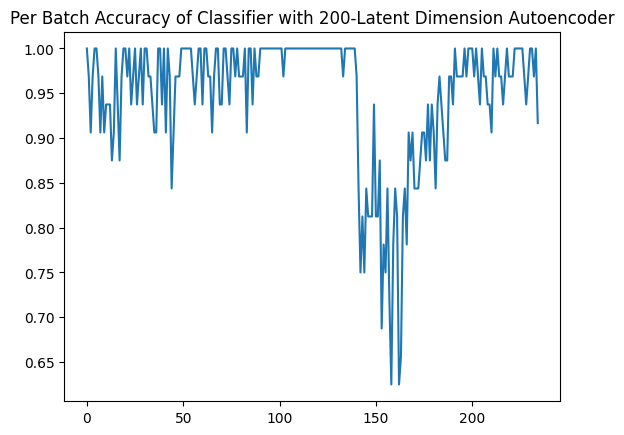

In [169]:
graph_loss(test_history[0], "Per Batch Accuracy of Classifier with 200-Latent Dimension Autoencoder")

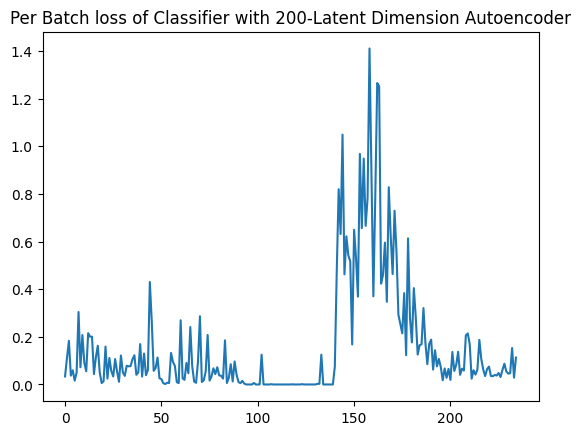

In [170]:
graph_loss(test_history[1], "Per Batch loss of Classifier with 200-Latent Dimension Autoencoder")

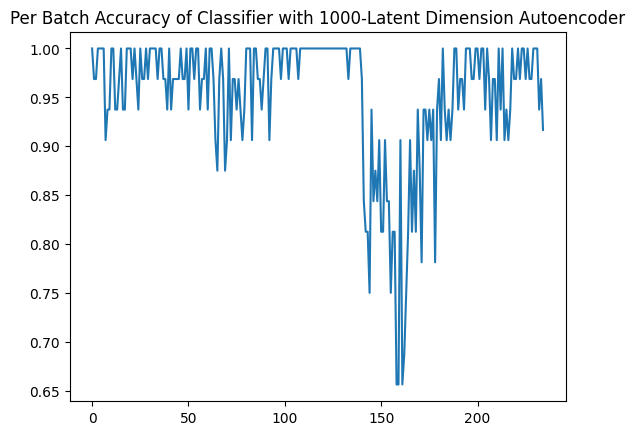

In [171]:
graph_loss(test_history_1000[0], "Per Batch Accuracy of Classifier with 1000-Latent Dimension Autoencoder")

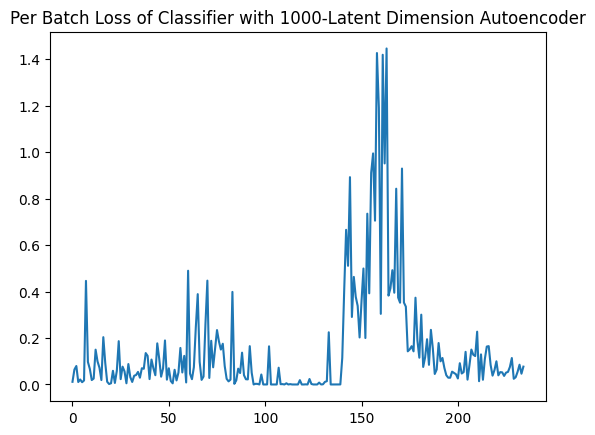

In [172]:
graph_loss(test_history_1000[1], "Per Batch Loss of Classifier with 1000-Latent Dimension Autoencoder")

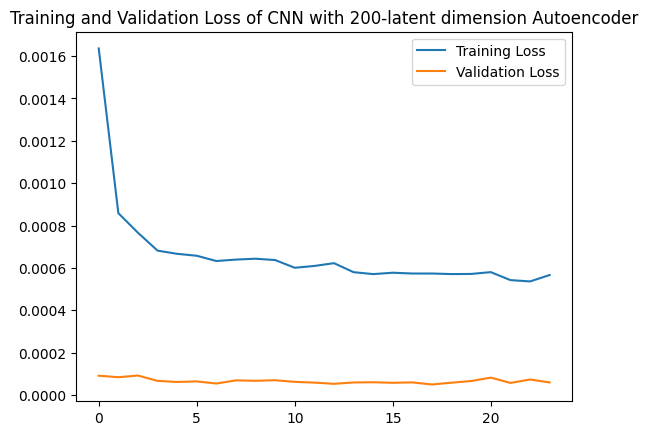

In [197]:
graph_train_valid(train_history[1], train_history[0], title="Training and Validation Loss of CNN with 200-latent dimension Autoencoder")

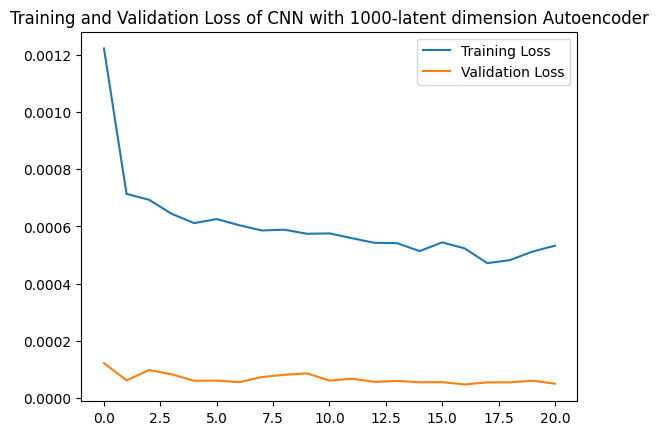

In [198]:
graph_train_valid(train_history_1000[1], train_history_1000[0], title="Training and Validation Loss of CNN with 1000-latent dimension Autoencoder")

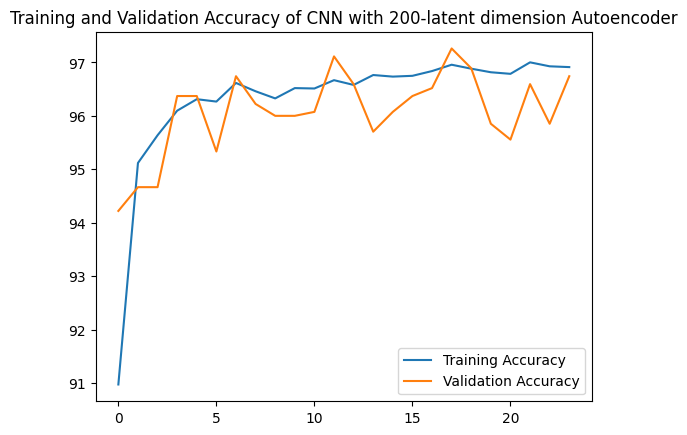

In [200]:
# a = [x * 100 for x in list(train_history[3].values())]
# update_accuracy(train_history[3])
graph_train_valid(train_history[2], train_history[3], title="Training and Validation Accuracy of CNN with 200-latent dimension Autoencoder", label1="Training Accuracy", label2="Validation Accuracy", location="lower right")

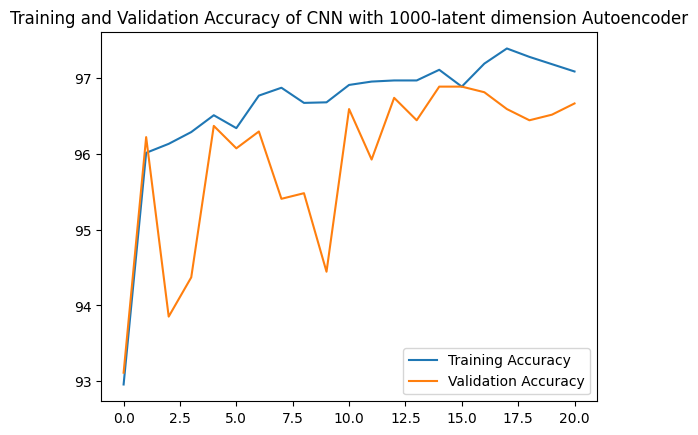

In [202]:
# update_accuracy(train_history_1000[3])
graph_train_valid(train_history_1000[2], train_history_1000[3], title="Training and Validation Accuracy of CNN with 1000-latent dimension Autoencoder", label1="Training Accuracy", label2="Validation Accuracy", location="lower right")

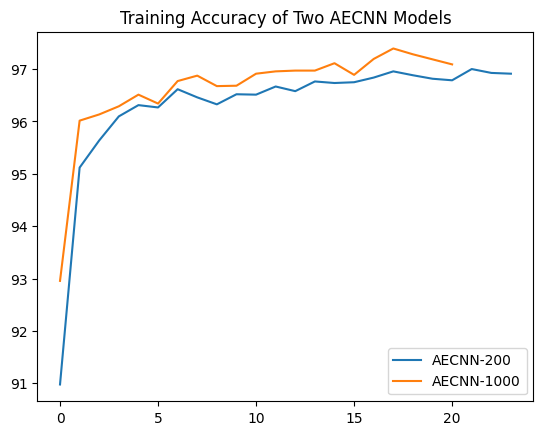

In [204]:
graph_train_valid(train_history[2], train_history_1000[2], title="Training Accuracy of Two AECNN Models", label1="AECNN-200", label2="AECNN-1000", location="lower right")

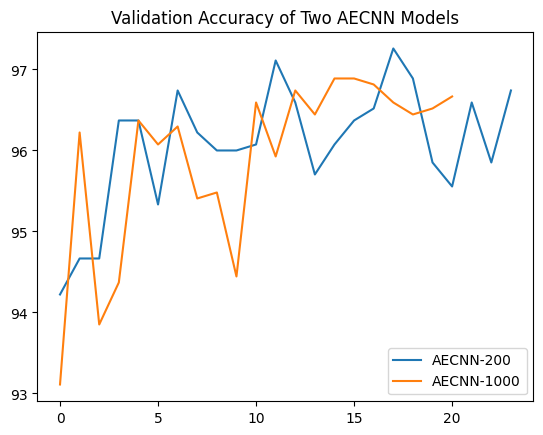

In [205]:
graph_train_valid(train_history[3], train_history_1000[3], title="Validation Accuracy of Two AECNN Models", label1="AECNN-200", label2="AECNN-1000", location="lower right")

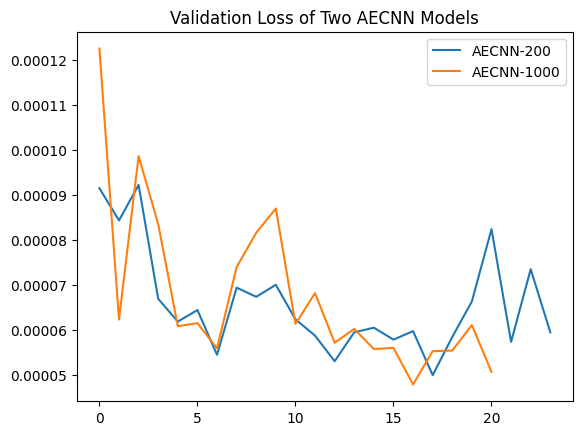

In [208]:
graph_train_valid(train_history[0], train_history_1000[0], title="Validation Loss of Two AECNN Models", label1="AECNN-200", label2="AECNN-1000")

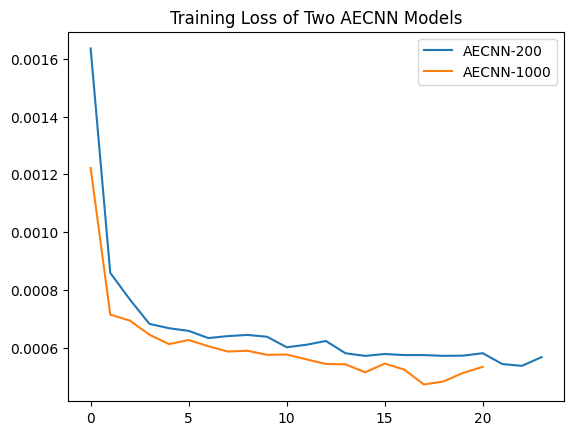

In [209]:
graph_train_valid(train_history[1], train_history_1000[1], title="Training Loss of Two AECNN Models", label1="AECNN-200", label2="AECNN-1000")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


155


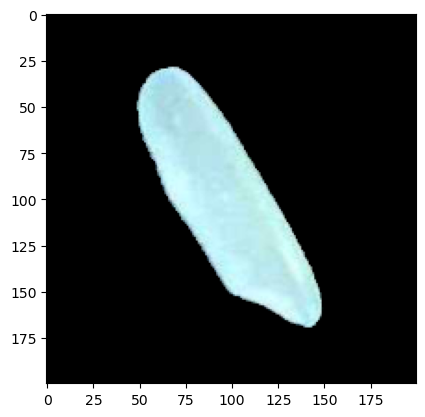

Label: 3
{0: 1500, 1: 1500, 2: 1500, 3: 1500, 4: 1500}


In [28]:
class_count = {
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0
}
for i, (images, labels) in enumerate(test_loader):
  for x, img  in enumerate(labels):
    class_count[labels[x].item()] += 1

  if i == 155:
    print(i)
    for x, img  in enumerate(images):
      plt.imshow(img.permute(1,2,0))
      plt.show()
      print(f"Label: {labels[x]}")
      break

print(class_count)

In [16]:
train_dataset.class_to_idx

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

In [29]:
tran_class_count = {
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0
}
for i, (images, labels) in enumerate(cl_train_loader):
    for x, img  in enumerate(labels):
        tran_class_count[labels[x].item()] += 1

In [30]:
tran_class_count

{0: 2645, 1: 2698, 2: 2747, 3: 2733, 4: 2677}